# Bootstrapping

Bootstrapping is a natural follow-up to ATE, not only because the two areas bear similarities, but also because bootstrapping complements ATE.
ATE gives a set of isolated concepts; bootstrapping gives those concepts more context by looking for closely-related terms.
In this way, bootstrapping enriches lexicons.

Before exploring and analysing the boostrapping, we load the required libraries.

In [1]:
import importlib
import json
import math
import os
import sys
import re

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patheffects as pe
import pandas as pd
from scipy.stats import shapiro, ttest_rel

sys.path.append(os.path.expanduser("~/GitHub/multiplex-plot"))
sys.path.append(os.path.expanduser("~/GitHub/EvenTDT"))
sys.path = list(set(sys.path))

from eventdt.objects.exportable import Exportable
from multiplex import drawable

ddir = os.path.expanduser('~/DATA/c4-ate/football/analyses/bootstrapping')
rdir = os.path.expanduser('~/DATA/c4-ate/football/analyses/bootstrapping/results-new-ap')
bbddir = os.path.expanduser('~/DATA/c4-ate/football/analyses/bootstrapping-baselines')
bbrdir = os.path.expanduser('~/DATA/c4-ate/football/analyses/bootstrapping-baselines/results-new-ap')
bddir = os.path.expanduser('~/DATA/c4-ate/football/analyses/verified')
brdir = os.path.expanduser('~/DATA/c4-ate/football/analyses/verified/results-new-ap')

In [2]:
with open(os.path.join(brdir, 'rank-50.json')) as rank_results, open(os.path.join(brdir, 'tfidf.json')) as tfidf_results:
    # decode the data and results
    rank, tfidf = json.loads(rank_results.readline()), json.loads(tfidf_results.readline())

    # load the summary results
    rank_ap = rank['results']['summary']['average precision']
    tfidf_ap = tfidf['results']['summary']['average precision']
    print(f"Average precision (Rank Difference): { round(rank_ap, 3) }")
    print(f"Average precision (TF-ICF): { round(tfidf_ap, 3) }")

Average precision (Rank Difference): 0.043
Average precision (TF-ICF): 0.041


Bootstrapping only improves TF-ICF by a slight margin.
Rank Difference benefits more from bootstrapping, but retains a relatively low AP compared to TF-ICF and EF-ICF-Entropy with bootstrapping.

In [3]:
# create the dataframe
bb_df = pd.DataFrame(columns=[ 'algorithm', 'method', 'seed', 'choose', 'ap', 'pk', 'lexicon' ])

for file in os.listdir(bbrdir):
    with open(os.path.join(bbddir, file)) as data, open(os.path.join(bbrdir, file)) as results:
        # decode the data and results
        data, results = json.loads(data.readline()), json.loads(results.readline())
        
        # load the data setup
        algorithm = 'tfidf' if 'tfidf' in data['cmd']['seed'] else 'rank'
        method = Exportable.get_class(data['pcmd']['method'])
        seed = len(data['pcmd']['seed'])
        choose = 'max' if 'max' in data['pcmd']['choose'] else 'mean'
        lexicon = data['pcmd']['seed'] + data['bootstrapped']
        
        # load the summary results
        summary = results['results']['summary']
        ap = results['results']['summary']['average precision']
        pk = results['results']['p@k']
        bb_df.loc[len(bb_df)] = { 'algorithm': algorithm, 'method': method, 'seed': seed, 'choose': choose,
                            'ap': ap, 'pk': pk, 'lexicon': lexicon }

bb_df = bb_df.sort_values(by=[ 'choose', 'seed', 'method' ])
bb_df = bb_df.reset_index(drop=True)
bb_df.head()
bb_df[ (bb_df.seed % 10 == 0) | True ].sort_values(by=[ 'algorithm', 'method', 'choose', 'ap' ], ascending=False)\
                                      .drop_duplicates([ 'algorithm', 'method', 'choose' ])

,algorithm,method,seed,choose,ap,pk,lexicon
53,tfidf,PMIBootstrapper,60,mean,0.039713,"{'1': 1, '2': 1.0, '3': 1.0, '4': 1.0, '5': 1....","[goal, score, game, player, penalti, ucl, seas..."
5,tfidf,LogLikelihoodRatioBootstrapper,10,mean,0.041876,"{'1': 1, '2': 1.0, '3': 1.0, '4': 1.0, '5': 1....","[goal, score, game, player, penalti, ucl, seas..."
2,tfidf,ChiBootstrapper,10,mean,0.043158,"{'1': 1, '2': 1.0, '3': 1.0, '4': 1.0, '5': 1....","[goal, score, game, player, penalti, ucl, seas..."
24,rank,PMIBootstrapper,30,mean,0.052775,"{'1': 1, '2': 0.5, '3': 0.3333333333333333, '4...","[ucl, chelsea, bbcfootbal, arsen, semi-fin, ha..."
3,rank,LogLikelihoodRatioBootstrapper,10,mean,0.053048,"{'1': 1, '2': 0.5, '3': 0.3333333333333333, '4...","[ucl, chelsea, bbcfootbal, arsen, semi-fin, ha..."
10,rank,ChiBootstrapper,20,mean,0.049294,"{'1': 1, '2': 0.5, '3': 0.3333333333333333, '4...","[ucl, chelsea, bbcfootbal, arsen, semi-fin, ha..."


Next, we load all the results into one DataFrame.
The analyses all take the top 200 terms produced earlier by an ATE algorithm and retain the best as the seed set.
The bootstrapper's task is to re-organize the rest of the terms, improving the overall quality of the ranking.
Therefore the precision, recall and F-measure do not change, which is why we mostly focus on the Average Precision in this notebook.

In [4]:
# create the dataframe
df = pd.DataFrame(columns=[ 'method', 'seed', 'choose', 'ap', 'pk', 'p50', 'p100', 'lexicon' ])

for file in os.listdir(rdir):
    if 'wmean' in file or 'median' in file:
        continue
    
    with open(os.path.join(ddir, file)) as data, open(os.path.join(rdir, file)) as results:
        # decode the data and results
        data, results = json.loads(data.readline()), json.loads(results.readline())
        
        # load the data setup
        method = Exportable.get_class(data['pcmd']['method'])
        seed = len(data['pcmd']['seed'])
        choose = 'max' if 'max' in data['pcmd']['choose'] else 'mean'
        lexicon = data['pcmd']['seed'] + data['bootstrapped']
        
        # load the summary results
        summary = results['results']['summary']
        ap = results['results']['summary']['average precision']
        pk = results['results']['p@k']
        if '50' not in pk:
            continue
        df.loc[len(df)] = { 'method': method, 'seed': seed, 'choose': choose,
                            'ap': ap, 'pk': pk, 'p50': pk['50'], 'p100': pk['100'],
                            'lexicon': lexicon }

df = df.sort_values(by=[ 'choose', 'seed', 'method' ])
df = df.reset_index(drop=True)
df.head()
df[ (df.seed % 10 == 0) | True ].sort_values(by=[ 'method', 'choose', 'ap' ], ascending=False)\
                       .drop_duplicates([ 'method', 'choose' ])

,method,seed,choose,ap,pk,p50,p100,lexicon
40,PMIBootstrapper,30,mean,0.034473,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...",0.56,0.42,"[baller, keeper, offsid, ff, equalis, gol, goa..."
14,PMIBootstrapper,50,max,0.032854,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...",0.50,0.42,"[baller, keeper, offsid, ff, equalis, gol, goa..."
39,LogLikelihoodRatioBootstrapper,30,mean,0.033780,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...",0.48,0.42,"[baller, keeper, offsid, ff, equalis, gol, goa..."
7,LogLikelihoodRatioBootstrapper,30,max,0.033374,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...",0.48,0.40,"[baller, keeper, offsid, ff, equalis, gol, goa..."
26,ChiBootstrapper,16,mean,0.037470,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...",0.54,0.45,"[baller, keeper, offsid, ff, equalis, gol, goa..."
6,ChiBootstrapper,30,max,0.035001,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...",0.52,0.44,"[baller, keeper, offsid, ff, equalis, gol, goa..."


## Best friends or popular terms?

The bootstrapping analyses use two modes to choose the terms to bootstrap.
The first method chooses the term that is closest to any term that is already in the seed set, or the `max` score method.
The second method chooses the term that is, on average, closest to the terms in the seed set, or the `mean` score method.

The two methods attract praise and criticism from literature.
Although some research obtained better results using the best score, bootstrapping terms even if they are very close to only one other term, others warned that relying on a single strong correlation could introduce noise.
In this section, we analyze which works best.

To analyze the results, we use the Paired Samples T-Test, which assumes that the samples in both have a Gaussian distribution.
We test this hypothesis using the Shapiro-Wilk Test for normality with the following hypotheses:

$H0$: The samples are normally-distributed

$H1$: The samples are not normally-distributed

In [5]:
# extract the data
max_results = df[ (df.choose == 'max') & (df.seed % 10 == 0) ].sort_values(by=[ 'method', 'seed' ])
mean_results = df[ (df.choose == 'mean') & (df.seed % 10 == 0) ].sort_values(by=[ 'method','seed' ])

stat, p = shapiro(max_results.ap)
if p > 0.05:
    print(f"Assuming that the maximum results are normally-distributed (failed to reject H0) ({ round(p, 4) })")
else:
    print(f"The maximum results are not normally-distributed (reject H0) ({ round(p, 4) })")
    
stat, p = shapiro(mean_results.ap)
if p > 0.05:
    print(f"Assuming that the mean results are normally-distributed (failed to reject H0) ({ round(p, 4) })")
else:
    print(f"The mean results are not normally-distributed (reject H0) ({ round(p, 4) })")
    
print(max_results.head())
print(mean_results.head())

Assuming that the maximum results are normally-distributed (failed to reject H0) (0.529)
Assuming that the mean results are normally-distributed (failed to reject H0) (0.7884)
             method seed choose        ap  \
0   ChiBootstrapper   10    max  0.033784   
3   ChiBootstrapper   20    max  0.034676   
6   ChiBootstrapper   30    max  0.035001   
9   ChiBootstrapper   40    max  0.033831   
12  ChiBootstrapper   50    max  0.033761   

                                                   pk   p50  p100  \
0   {'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...  0.52  0.44   
3   {'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...  0.52  0.44   
6   {'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...  0.52  0.44   
9   {'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...  0.48  0.43   
12  {'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...  0.50  0.43   

                                              lexicon  
0   [baller, keeper, offsid, ff, equalis, gol, goa...  
3   [baller, keeper, offsi

Since both the maximum and mean results are normally-distributed, we can safely use the Paired Samples T-Test.
Here, we use a one-sided alternative hypothesis that the average of the mean population, $u_{mean}$, is greater than the average of the max population, $u_{max}$.
In other words, bootstrapping terms that are similar to several seed terms is better than bootstrapping terms that are highly similar to one other term.

$H0: u_{mean} = u_{max}$

$H1: u_{mean} > u_{max}$

In [6]:
print(f"Average (mean)  { round(sum(mean_results.ap)/len(mean_results.ap), 4) }")
print(f"Average (max)   { round(sum(max_results.ap)/len(max_results.ap), 4) }")
print(f"{ len([ True for _max, _mean in zip(max_results.ap, mean_results.ap) if _mean > _max ]) } out of { len(mean_results) } MEAN models outperformed MAX models")

print()
for i, (_max, _mean) in enumerate(zip(max_results.ap, mean_results.ap)):
    if _max > _mean:
        print(f"{ max_results.iloc[i].method } ({ max_results.iloc[i].choose }) with { max_results.iloc[i].seed } seeds: { max_results.iloc[i].ap } AP")
        print(f"{ mean_results.iloc[i].method } ({ mean_results.iloc[i].choose }) with { mean_results.iloc[i].seed } seeds: { mean_results.iloc[i].ap } AP")
        print()

stat, p = ttest_rel(mean_results.ap, max_results.ap, alternative='greater')
if p > 0.05:
    print(f"The means of both population samples are the same (failed to reject H0) ({ round(p, 4) })")
else:
    print(f"The population average when using the mean score is greater than when using the maximum score (reject H0) ({ round(p, 4) })")

Average (mean)  0.0336
Average (max)   0.033
15 out of 18 MEAN models outperformed MAX models

ChiBootstrapper (max) with 40 seeds: 0.0338314855046343 AP
ChiBootstrapper (mean) with 40 seeds: 0.0335490095287268 AP

ChiBootstrapper (max) with 50 seeds: 0.033761081725813095 AP
ChiBootstrapper (mean) with 50 seeds: 0.033501319519410835 AP

ChiBootstrapper (max) with 60 seeds: 0.033343390093868726 AP
ChiBootstrapper (mean) with 60 seeds: 0.03315182413181678 AP

The population average when using the mean score is greater than when using the maximum score (reject H0) (0.0007)


**Conclusion:** Using the average score of a candidate term with the other terms out-performs using the best score.

Without delving into the minutae of why the mean score out-peforms the best score, the intuition is, at least, sound.
Using the best score avoids incorrect seed terms polluting the rest of the lexicon, for example nominating the word *Gea* because the ATE algorithm (or the bootstrapper itself) had previously chosen *De*.
On the contrary, using the mean score gives more reliable terms because they relate to more than just one term.

## More or less: the effect of the number of seed terms on bootstrapping

One major difficulty with bootstrapping is choosing the number of seed terms to start with.
Having a high-quality seed set is essential to bootstrapping's success.
Next, we analyse how modifying the seed set size affects bootstrapping.

In [7]:
_df = df[ (df.choose == 'mean') & (df.method == 'ChiBootstrapper') ]
_df.sort_values(by=[ 'seed' ], ascending=True).head(10)

,method,seed,choose,ap,pk,p50,p100,lexicon
18,ChiBootstrapper,10,mean,0.035079,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...",0.54,0.44,"[baller, keeper, offsid, ff, equalis, gol, goa..."
21,ChiBootstrapper,11,mean,0.034874,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...",0.54,0.45,"[baller, keeper, offsid, ff, equalis, gol, goa..."
22,ChiBootstrapper,12,mean,0.036565,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...",0.54,0.44,"[baller, keeper, offsid, ff, equalis, gol, goa..."
23,ChiBootstrapper,13,mean,0.036416,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...",0.56,0.44,"[baller, keeper, offsid, ff, equalis, gol, goa..."
24,ChiBootstrapper,14,mean,0.036612,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...",0.52,0.44,"[baller, keeper, offsid, ff, equalis, gol, goa..."
25,ChiBootstrapper,15,mean,0.036679,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...",0.54,0.44,"[baller, keeper, offsid, ff, equalis, gol, goa..."
26,ChiBootstrapper,16,mean,0.037470,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...",0.54,0.45,"[baller, keeper, offsid, ff, equalis, gol, goa..."
27,ChiBootstrapper,17,mean,0.036818,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...",0.54,0.45,"[baller, keeper, offsid, ff, equalis, gol, goa..."
28,ChiBootstrapper,18,mean,0.035838,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...",0.52,0.45,"[baller, keeper, offsid, ff, equalis, gol, goa..."
29,ChiBootstrapper,19,mean,0.035509,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...",0.52,0.45,"[baller, keeper, offsid, ff, equalis, gol, goa..."


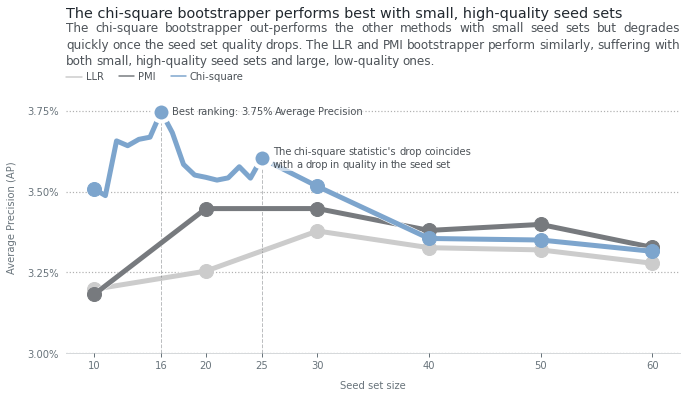

In [8]:
# prepare the data
_df = df[ (df.choose == 'mean') ]
metric = 'ap'
best = _df[ (_df.method == 'ChiBootstrapper') & (_df.seed == 16) ].iloc[0]
annotations = { 
    best.seed: f"Best ranking: { '{:.2f}%'.format(round(best[metric], 4) * 100) } Average Precision",
    25: "The chi-square statistic's drop coincides with a drop in quality in the seed set"
}

# create a style
plt.style.use(os.path.join(os.getcwd(), '../modern-custom.style'))
style = { 'linewidth': 5, 'with_legend': True,
          'path_effects': [ pe.Stroke(linewidth=6, foreground='C4'), pe.Normal(), ] }
marker_style = { 'marker': 'o', 'markersize': 14 }
scatter_style = { 's': marker_style['markersize'] ** 2, 'zorder': 6 }
annotation_marker_style = dict(marker_style)
annotation_marker_style.update({ 'markersize': 18, 'markeredgewidth': 4, 'markeredgecolor': 'C4', 'zorder': 7 }) # 18-4=14 (markersize)
line_style = { 'alpha': 0.3, 'linestyle': '--', 'linewidth': 1 }
annotation_style = { 'fontsize': 'smaller', 'va': 'center', 'alpha': 0.8, 'facecolor': '#ffffff99', 'zorder': 10 }

# draw the visualization
figure = plt.figure(figsize=(11, 5))
viz = drawable.Drawable(figure)
viz.draw_time_series(_df[_df.method == 'LogLikelihoodRatioBootstrapper'].seed, _df[_df.method == 'LogLikelihoodRatioBootstrapper'][metric],
                     'LLR', color='C5', zorder=1, **style)
viz.plot(_df[_df.method == 'LogLikelihoodRatioBootstrapper'].seed, _df[_df.method == 'LogLikelihoodRatioBootstrapper'][metric],
         color='C5', zorder=2, **marker_style)
viz.draw_time_series(_df[_df.method == 'PMIBootstrapper'].seed, _df[_df.method == 'PMIBootstrapper'][metric],
                     'PMI', color='C3', zorder=3, **style)
viz.plot(_df[_df.method == 'PMIBootstrapper'].seed, _df[_df.method == 'PMIBootstrapper'][metric],
         color='C3', zorder=4, **marker_style)
viz.draw_time_series(_df[_df.method == 'ChiBootstrapper'].seed, _df[_df.method == 'ChiBootstrapper'][metric],
                     'Chi-square', color='C1', zorder=5, **style)

# re-using PMIBootstrapper's index because the chi-square has extra seeds
_x = _df[(_df.method == 'PMIBootstrapper') & ((_df.seed > 25) | (_df.seed == 10))].seed.tolist()
_y = _df[(_df.method == 'ChiBootstrapper') & (_df.seed.isin(_x))][metric]
viz.scatter(_x, _y, color='C1', **scatter_style)

yticks = [ _y/10000 for _y in range(300, 375+1, 25) ]
yticklabels = [ '{:.2f}%'.format(round(tick * 100, 4)) for tick in yticks ]
viz.set_ylim(min(yticks), max(yticks)+0.0009)

# draw the annotations
ylim = viz.get_ylim()
for x, label in annotations.items():
    _y = _df[ (_df.method == 'ChiBootstrapper') & ( _df.seed == x ) ].iloc[0][metric]
    viz.vlines(x, ymin=ylim[0], ymax=_y, **line_style)
    viz.plot(x, _y, color='C1', **annotation_marker_style)
    viz.annotate(label, (x + 1, x + 20), _y, **annotation_style)

# finalize the visualization
viz.set_xticks(sorted(set(list(range(10, max(_df.seed) + 1, 10)) + list(annotations.keys()))) )
viz.set_xlabel('Seed set size')
viz.set_ylabel('Average Precision (AP)')
viz.set_yticks(yticks)
viz.set_yticklabels(yticklabels)
viz.set_axisbelow(True)
viz.set_title("The chi-square bootstrapper performs best with small, high-quality seed sets", loc='left')
viz.set_caption(f"""The chi-square bootstrapper out-performs the other methods with small seed sets but degrades quickly once the seed set quality drops.
                    The LLR and PMI bootstrapper perform similarly, suffering with both small, high-quality seed sets and large, low-quality ones.""",
                align='justify')
viz.savefig('../exports/4.3-bootstrapping-seed-set-size.png', dpi=300, bbox_inches='tight')

**Conclusion:** The chi-square statistic relies on a quality seed set, not a large seed set.

The chi-square statistic's performance as a bootstrapper remains high as long as the seed set's quality is also high.
When the seed set's quality dips, so does chi-square's performance—dramatically.

Still, at its best, the chi-square statistic greatly outperforms the Log Likelihood Ratio and PMI.
The two metrics, especially the Log Likelihood Ratio, rely on a large seed set, so they fail to exploit the quality of the top terms.
By the time the seed set is large enough, the bootstrapper's input is too noisy to improve.

## Understanding bootstrapping's improvements

The last analysis looks at how and when understanding bootstrapping improves the original algorithm's lexicon.
We start by loading the EF-ICF-Entropy's lexicon results, which is what bootstrapping used for its candidate list.
This time, we load only the P@k results, but we print the average precision.

In [9]:
with open(os.path.join(bddir, 'ef-idf-entropy.json')) as data, open(os.path.join(brdir, 'ef-idf-entropy.json')) as results:
    # decode the data and results
    data, results = json.loads(data.readline()), json.loads(results.readline())
    base_lexicon = [ term['term'] for term in data['terms'][:200] ]

    # load the summary results
    summary = results['results']['summary']
    bpk = results['results']['p@k']
    ap = summary['average precision']
    print(f"Average precision (original lexicon): { round(ap, 3) }")

Average precision (original lexicon): 0.032


In [10]:
degraded = df[ df.ap <= ap ]
print(f"Only { len(degraded) } out of { len(df) } bootstrapping approaches did not improve EF-ICF-Entropy's base average precision")
degraded
print(f"The best method improves precision by { round(best.ap / ap * 100 - 100) }%")
degraded

Only 3 out of 50 bootstrapping approaches did not improve EF-ICF-Entropy's base average precision
The best method improves precision by 17%


,method,seed,choose,ap,pk,p50,p100,lexicon
1,LogLikelihoodRatioBootstrapper,10,max,0.031090,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...",0.44,0.39,"[baller, keeper, offsid, ff, equalis, gol, goa..."
2,PMIBootstrapper,10,max,0.031757,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...",0.50,0.38,"[baller, keeper, offsid, ff, equalis, gol, goa..."
20,PMIBootstrapper,10,mean,0.031821,"{'1': 0, '2': 0.5, '3': 0.6666666666666666, '4...",0.52,0.41,"[baller, keeper, offsid, ff, equalis, gol, goa..."


**Conclusion:** Bootstrapping improves results almost immediately and maintains a high precision for a long time.

The next visualization shows two interesting outcomes.
The first take-away is that bootstrapping leads to an almost-immediate improvement in results.
EF-ICF-Entropy out-performs bootstrapping briefly, but the chi-square statistic catches up rapidly.
Worse, while the next drop is unforgiving for both EF-ICF-Entropy and the chi-square statistic, bootstrapping retains a precision higher than 50% for almost half the ranking.
At this point, the difference between the simple ATE algorithm and bootstrapping is at its clearest.

The second take-away is the way in which bootstrapping loses its quality.
After around the 75th term, bootstrapping stops improving.
Bootstrapping's descent in results is consistent, unlike EF-ICF-Entropy's, whose results improve momentarily every now and then even in the later stages.
This unwavering decline signals that bootstrapping exhausts most valid terms relatively early on, fulfilling its role.

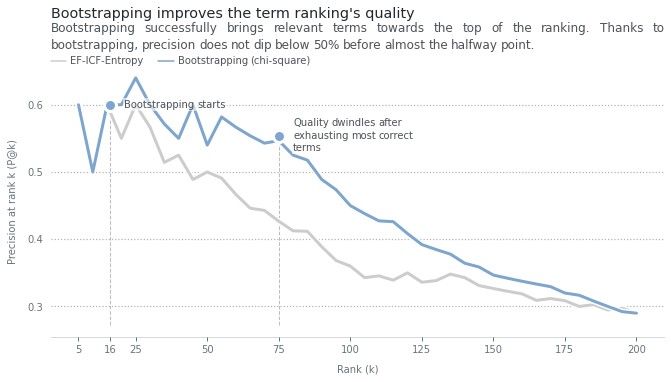

In [11]:
# prepare the data
at = df[ df.ap == df.ap.max() ].iloc[0].seed
pk = df[ (df.method == 'ChiBootstrapper') & (df.seed == at) & (df.choose == 'mean') ].iloc[0].pk
_x = list(range(5, len(pk) + 1, 5))
_y = [ pk[f"{ __x }"] for __x in _x ]
_by = [ bpk[f"{ __x }"] for __x in _x ]
annotations = {
    at: 'Bootstrapping starts',
    75: 'Quality dwindles after exhausting most correct terms'
}

# create a style for the precision
plt.style.use(os.path.join(os.getcwd(), '../modern-custom.style'))
style = { 'linewidth': 3, 'with_legend': True,
          'path_effects': [ pe.Stroke(linewidth=6, foreground='C4'), pe.Normal() ] }
marker_style = { 'marker': 'o', 'markersize': 12, 
                 'markeredgewidth': 3, 'markeredgecolor': 'C4' }
line_style = { 'alpha': 0.3, 'linestyle': '--', 'linewidth': 1 }
annotation_style = { 'fontsize': 'smaller', 'va': 'center', 'alpha': 0.8, 'pad': 0, 'facecolor': '#ffffff99' }

# draw the visualization
figure = plt.figure(figsize=(11, 5))
viz = drawable.Drawable(figure)
viz.draw_time_series(_x, _by, 'EF-ICF-Entropy', color='C5', **style)
viz.draw_time_series(_x, _y, 'Bootstrapping (chi-square)', color='C1', **style)

# draw the annotations
ylim = viz.get_ylim()
for x, label in annotations.items():
    _y = pk[f"{ x - 1 }"]
    viz.vlines(x, ymin=ylim[0], ymax=_y, **line_style)
    viz.plot(x, _y, color='C1', **marker_style)
    viz.annotate(label, (x + 5, x + 50), _y, **annotation_style)

# finalize the visualization
viz.set_xlabel('Rank (k)')
viz.set_xticks(list(set(list(range(25, max(_x) + 1, 25)) + [ min(_x), at ])))
viz.set_ylabel('Precision at rank k (P@k)')
viz.set_yticks([ _y/100 for _y in range(30, 60 + 1, 10) ])
viz.set_title("Bootstrapping improves the term ranking's quality", loc='left')
viz.set_caption(f"""Bootstrapping successfully brings relevant terms towards the top of the ranking.
                    Thanks to bootstrapping, precision does not dip below 50% before almost the halfway point.""",
                align='justify')
viz.savefig('../exports/4.3-bootstrapping-quality-at-k.png', dpi=300, bbox_inches='tight')

In [12]:
below_50 = [ int(k) for k, p in pk.items() if p < 0.5 and int(k) >= at ]
k = str(min(below_50)-1)
print(f"Precision remains above 50% until k={ (k) }")
print(f"EF-ICF-Entropy has { round(bpk[k] * 100) }% precision at k={ k }")
print()

best_rank = bb_df[bb_df.algorithm == 'rank'].sort_values(by=[ 'ap' ], ascending=False).iloc[0]
print(best_rank)
print(f"Rank Difference (with bootstrapping) has { round(best_rank.pk[k] * 100) }% precision at k={ k }")
print()

best_tfidf = bb_df[bb_df.algorithm == 'tfidf'].sort_values(by=[ 'ap' ], ascending=False).iloc[0]
print(f"TF-ICF (with bootstrapping) has { round(best_tfidf.pk[k] * 100) }% precision at k={ k }")
print(best_tfidf)

Precision remains above 50% until k=88
EF-ICF-Entropy has 40% precision at k=88

algorithm                                                 rank
method                          LogLikelihoodRatioBootstrapper
seed                                                        10
choose                                                    mean
ap                                                   0.0530481
pk           {'1': 1, '2': 0.5, '3': 0.3333333333333333, '4...
lexicon      [ucl, chelsea, bbcfootbal, arsen, semi-fin, ha...
Name: 3, dtype: object
Rank Difference (with bootstrapping) has 52% precision at k=88

TF-ICF (with bootstrapping) has 47% precision at k=88
algorithm                                                tfidf
method                                         ChiBootstrapper
seed                                                        10
choose                                                    mean
ap                                                   0.0431579
pk           {'1': 1, 

The curve is not surprising if you look at which terms the bootstrapper boosted, and which terms it dropped.
Words like *net*, *decis[ion]* and *corner* receive huge boosts, inspite of some noisier keywords, like *arsen[al]*.
At the other end the only questionable drop is *freekick*, possibly because it is a misspelling of *free-kick*.
The other nine keywords with the largest drops, however, are all noisy and opinionated, as characterized by *masterclass*, *wow* or *wtf*.

In [13]:
lexicon = df[ df.ap == df.ap.max() ].iloc[0].lexicon

# positive change: bootstrapping boosted the term
# negative change: bootstrapping degraded the term
changes = { term: base_lexicon.index(term) - lexicon.index(term) for term in lexicon }
changes = sorted(changes.items(), key=lambda x: x[1], reverse=True)

print("Boosted (increase)")
for term, change in changes[:10]:
    bi, li = base_lexicon.index(term) + 1, lexicon.index(term) + 1
    print(f"    { term } (+{ change }) ({ bi } ⇒ { li })")

print()
print("Dropped (decrease)")
for term, change in changes[-10:]:
    bi, li = base_lexicon.index(term) + 1, lexicon.index(term) + 1
    print(f"    { term } ({ change }) ({ bi } ⇒ { li })")

Boosted (increase)
    net (+160) (193 ⇒ 33)
    decis (+156) (178 ⇒ 22)
    clear (+145) (177 ⇒ 32)
    arsen (+145) (191 ⇒ 46)
    need (+142) (181 ⇒ 39)
    corner (+133) (174 ⇒ 41)
    take (+126) (166 ⇒ 40)
    onlin (+123) (172 ⇒ 49)
    post (+115) (184 ⇒ 69)
    live (+114) (162 ⇒ 48)

Dropped (decrease)
    nah (-115) (63 ⇒ 178)
    lmao (-116) (52 ⇒ 168)
    motm (-122) (60 ⇒ 182)
    useless (-126) (34 ⇒ 160)
    sack (-128) (48 ⇒ 176)
    unreal (-138) (50 ⇒ 188)
    wtf (-140) (26 ⇒ 166)
    wow (-142) (33 ⇒ 175)
    masterclass (-146) (27 ⇒ 173)
    freekick (-155) (17 ⇒ 172)
